### 0. References

https://github.com/Tramac/awesome-semantic-segmentation-pytorch

https://github.com/cocodataset/cocoapi

https://gaussian37.github.io/vision-segmentation-fcn/

https://gaussian37.github.io/vision-segmentation-pspnet/

https://pytorchhair.gitbook.io/project/undefined/pspnet

https://devkor.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84-%ED%86%B5%ED%95%9C-Image-Segmentation-%EC%9E%85%EB%AC%B8

### 1. Import Libraries

In [ ]:
import time
import numpy as np
import os
import pickle
import datetime
from tqdm import tqdm
from tqdm import trange
from PIL import Image
from segbase import SegmentationDataset
from loss import get_segmentation_loss
from distributed import *
from score import SegmentationMetric
from visualize import get_color_pallete
from visualize import _getvocpallete
from logger import setup_logger

import torch
from torch import nn, Tensor
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torchvision.models as models
from torchinfo import summary

from IPython.display import clear_output
from PIL import Image

from pycocotools.coco import COCO
from pycocotools import mask
import skimage.io as io

### 2. Set hyperparameters

In [ ]:
# training params
epochs=2
learning_rate=5e-4
batch_size=16

# Normalization Transform
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.485, .456, .406), (.229, .224, .225))])

# data params
data_kwargs = {'transform': input_transform, 'base_size': 320, 'crop_size': 256}

### 3. load / create Datasets

    Parameters
    ----------
    root : string
        Path to ADE20K folder. Default is './datasets/coco'
    split: string
        'train', 'val' or 'test'
    transform : callable, optional
        A function that transforms the image
    Examples
    --------
    >>> from torchvision import transforms
    >>> import torch.utils.data as data
    >>> # Transforms for Normalization
    >>> input_transform = transforms.Compose([
    >>>     transforms.ToTensor(),
    >>>     transforms.Normalize((.485, .456, .406), (.229, .224, .225)),
    >>> ])
    >>> # Create Dataset
    >>> trainset = COCOSegmentation(split='train', transform=input_transform)
    >>> # Create Training Loader
    >>> train_data = data.DataLoader(
    >>>     trainset, 4, shuffle=True,
    >>>     num_workers=4)
    

In [ ]:
class COCOSegmentation(SegmentationDataset):

    CAT_LIST = [0, 5, 2, 16, 9, 44, 6, 3, 17, 62, 21, 67, 18, 19, 4,
                1, 64, 20, 63, 7, 72]
    NUM_CLASS = 21

    def __init__(self, root='/home/JinK/coco/data', split='train', mode=None, transform=None, **kwargs):
        super(COCOSegmentation, self).__init__(root, split, mode, transform, **kwargs)
        # lazy import pycocotools
        from pycocotools.coco import COCO
        from pycocotools import mask
        if split == 'train':
            print('train set')
            ann_file = os.path.join(root, 'annotations/instances_train2017.json')
            ids_file = os.path.join(root, 'annotations/train_ids.mx')
            self.root = os.path.join(root, 'train2017')
        else:
            print('val set')
            ann_file = os.path.join(root, 'annotations/instances_val2017.json')
            ids_file = os.path.join(root, 'annotations/val_ids.mx')
            self.root = os.path.join(root, 'val2017')
        self.coco = COCO(ann_file)
        self.coco_mask = mask
        if os.path.exists(ids_file):
            with open(ids_file, 'rb') as f:
                self.ids = pickle.load(f)
        else:
            ids = list(self.coco.imgs.keys())
            self.ids = self._preprocess(ids, ids_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):  
        coco = self.coco
        img_id = self.ids[index]
        img_metadata = coco.loadImgs(img_id)[0]
        path = img_metadata['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        cocotarget = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        mask = Image.fromarray(self._gen_seg_mask(
            cocotarget, img_metadata['height'], img_metadata['width']))
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask, os.path.basename(os.path.join(self.root, path))

    def _mask_transform(self, mask):
        return torch.LongTensor(np.array(mask).astype('int32'))

    def _gen_seg_mask(self, target, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        coco_mask = self.coco_mask
        for instance in target:
            rle = coco_mask.frPyObjects(instance['segmentation'], h, w)
            m = coco_mask.decode(rle)
            cat = instance['category_id']
            if cat in self.CAT_LIST:
                c = self.CAT_LIST.index(cat)
            else:
                continue
            if len(m.shape) < 3:
                mask[:, :] += (mask == 0) * (m * c)
            else:
                mask[:, :] += (mask == 0) * (((np.sum(m, axis=2)) > 0) * c).astype(np.uint8)
        return mask

    def _preprocess(self, ids, ids_file):
        print("Preprocessing mask, this will take a while." + \
              "But don't worry, it only run once for each split.")
        tbar = trange(len(ids))
        new_ids = []
        for i in tbar:
            img_id = ids[i]
            cocotarget = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
            img_metadata = self.coco.loadImgs(img_id)[0]
            mask = self._gen_seg_mask(cocotarget, img_metadata['height'], img_metadata['width'])
            # more than 1k pixels
            if (mask > 0).sum() > 1000:
                new_ids.append(img_id)
            tbar.set_description('Doing: {}/{}, got {} qualified images'. \
                                 format(i, len(ids), len(new_ids)))
        print('Found number of qualified images: ', len(new_ids))
        with open(ids_file, 'wb') as f:
            pickle.dump(new_ids, f)
        return new_ids

    @property
    def classes(self):
        """Category names."""
        return ('background', 'airplane', 'bicycle', 'bird', 'boat', 'bottle',
                'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                'motorcycle', 'person', 'potted-plant', 'sheep', 'sofa', 'train',
                'tv')

In [ ]:
# Create Dataset
train_set = COCOSegmentation(split='train', mode='train', **data_kwargs)

In [ ]:
# Create Train Loader
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

### 4. Build Network model

##### 1) FCNet type

In [ ]:
from torchvision import models
from torchvision.models.vgg import VGG


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}
        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output

class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def lower(self):
        return self
        
    def forward(self, x):
        outputs = []
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        outputs.append(score)

        return tuple(outputs)  # size=(N, n_class, x.H/1, x.W/1)

In [ ]:
# Create FCN model instance
vgg_model = VGGNet(requires_grad=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=train_set.num_class)

In [ ]:
print(summary(fcn_model, input_size=(16, 3, 256, 256), verbose=0))

##### 2) PSPNet type

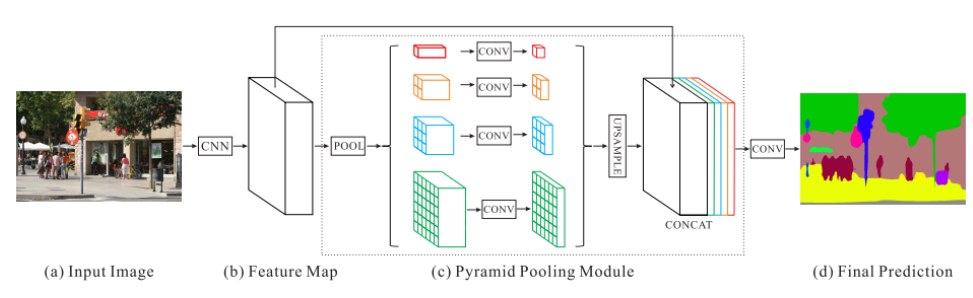

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, nclass):
        super(BaseModel, self).__init__()
        self.nclass = nclass
        model = models.resnet50(pretrained=True, replace_stride_with_dilation=[False, True, True])
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x 

In [ ]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channel, nclass, midReduction=4, out_channel=512, sizes=(1,2,3,6)):
        super(PyramidPooling, self).__init__()
        self.mid_channel = int(in_channel/midReduction) #1x1Conv channel num, defalut=512
        self.stages = []
        # 각 sub-region을 ModuleList로 모음
        self.stages = nn.ModuleList([self._make_stage(in_channel, self.mid_channel, size) for size in sizes])  #pooling->conv1x1
        # concatenation한 feature들에 convolution 적용
        self.bottleneck = nn.Conv2d( (in_channel+ self.mid_channel*4), out_channel, kernel_size=3, padding=1)  #channel: 4096->512 1x1
        self.bn = nn.BatchNorm2d(out_channel)
        self.prelu = nn.PReLU()
        
    # 각 sub-regsion의 Average Pooling과 Convolution 연산을 하는 함수
    def _make_stage(self, in_channel, mid_channel, size):
        
        # Average Pooling으로 (size, size) 크기의 sub-region을 생성합니다.
        pooling = nn.AdaptiveAvgPool2d(output_size=(size, size))
        # sub-region을 1x1 convolution으로 채널 수를 midChannel 만큼 증감 시킵니다.
        Conv = nn.Conv2d(in_channel, mid_channel, kernel_size=1, bias=False)
        
        return nn.Sequential(pooling, Conv)
    
    def forward(self, feats):
        
        # 입력으로 들어온 feature의 height, width 사이즈를 구합니다.
        h, w = feats.size(2), feats.size(3)
        # 각 sub-region을 input feature 크기로 billinear-interpolation을 합니다.
        # stage(feats)는 input feature를 각 sub-region 형태로 구한 feature를 뜻합니다.
        mulBranches = [F.interpolate(input=stage(feats), size=(h, w), mode='bilinear', align_corners=True) for stage in self.stages] + [feats]
        # interpolation 한 각 sub-region을 concatenation 하여 하나의 feature로 만듭니다.
        out = self.bottleneck(torch.cat((mulBranches[0], mulBranches[1], mulBranches[2], mulBranches[3], feats), 1))
        # batch-normalation 적용
        out = self.bn(out)
        # prelu 적용
        out = self.prelu(out)
        
        return out

In [ ]:
class PSPNet(BaseModel):
    def __init__(self, nclass):
        super(PSPNet, self).__init__(nclass)
        self.pyramid = PyramidPooling(2048, nclass)
        self.base_forward = BaseModel(nclass)
        self.lastconv = nn.Conv2d(512, nclass, 1)
        
    def lower(self):
        return self
    
    def forward(self, x):
        # input size (H, W)
        size = x.size()[2:]
        # go through basemodel 
        base_out = self.base_forward(x)
        outputs = []
        # go through pyramid pooling
        x = self.pyramid(base_out)
        # out channel 이 num of classes 인 마지막 conv layer
        x = self.lastconv(x)
        # upsampling with bilinear interpolation
        x = F.interpolate(x, size=size, mode='bilinear', align_corners=True)
        outputs.append(x)
        return tuple(outputs)

In [ ]:
backbone = BaseModel(nclass=train_set.num_class)
psp_model = PSPNet(nclass=train_set.num_class)

In [ ]:
print(summary(psp_model, input_size=(16, 3, 256, 256), verbose=0))

### 5. Define loss, accuracy

In [ ]:
# set device
device = 'cuda'

# create criterion
criterion = get_segmentation_loss(psp_model, ignore_index=-1).to(device)

# evaluation metrics
metric = SegmentationMetric(train_set.num_class)

### 6. Select Optimizer

In [ ]:
# declare optimizer
optimizer = torch.optim.Adam(psp_model.parameters(), lr=learning_rate, weight_decay=1e-5)

### 7. Train and validate model (save model as train)

In [ ]:
# set device
device = 'cuda'
# model = fcn_model.to(device)
model = psp_model.to(device)
# set logger
logger = setup_logger("semantic_segmentation", '/home/JinK/coco/runs/logs', get_rank(),
                      filename='{}_{}_train_log.txt'.format(model.__class__.__name__, 'ResNet50'), mode='a+')

for ep in range(epochs):

    model.train()
    train_loss = 0
    start_time = time.time()
    
    with tqdm(total=len(train_loader.dataset)) as progress_bar:
        for i, (images, targets, _) in enumerate(train_loader):
            optimizer.zero_grad()
            
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            # outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor)

            loss_dict = criterion(outputs, targets)

            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()
            
            train_loss += losses
            avg_loss = (train_loss / i)
            
            progress_bar.set_postfix(loss=avg_loss)
            progress_bar.update(images.size(0))
        
            if i % 10 == 0:
                print('saving model')
                torch.save(model.state_dict(), f'models/{model.__class__.__name__}-iter{i+1}.pth')
    
    print(f'Epoch {ep} | L: {avg_loss:.7f}')
    
    logger.info("Epoch : {:d} | Lr: {:.6f} | Loss: {:.4f} | Cost Time: {}".format(
                    ep, max_iters, self.optimizer.param_groups[0]['lr'], avg_loss,
                    str(datetime.timedelta(seconds=int(time.time() - start_time)))))
    
#     # save model after specified epochs
#     if e+1 % 5 == 0:
#         torch.save(model.state_dict(), f'models/{model.__class__.__name__}-e{e+1}.pth')

torch.cuda.empty_cache()

### 8. Load model and test / predict

In [ ]:
# Create testval set and loader
testval_set = COCOSegmentation(split='val', mode='val', **data_kwargs)
testval_loader = data.DataLoader(testval_set, batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda'

# load model
vgg_model = VGGNet(requires_grad=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=testval_set.num_class)
model = fcn_model.to(device)
model.load_state_dict(torch.load(f'models/{model.__class__.__name__}-e10.pth'))


metric = SegmentationMetric(testval_set.num_class)

outdir = '/home/JinK/coco/runs/pred_pic/{}_coco'.format(model.__class__.__name__)
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [ ]:
logger = setup_logger("semantic_segmentation", '/home/JinK/coco/runs/logs', get_rank(),
                      filename='{}_{}_acc_log.txt'.format(model.__class__.__name__, vgg_model.__class__.__name__), mode='a+')

model.eval()
for i, (images, targets, filename) in enumerate(testval_loader):
    images = images.to(device)
    targets = targets.to(device)
    
    with torch.no_grad():
        outputs = model(images)
    metric.update(outputs[0], targets)
    pixAcc, mIoU = metric.get()
    
    pred = torch.argmax(outputs[0], 1)
    pred = pred.cpu().data.numpy()
    
    logger.info("Sample: {:d}, validation pixAcc: {:.3f}, mIoU: {:.3f}".format(
                i + 1, pixAcc * 100, mIoU * 100))
    
#     vocpallete = _getvocpallete(256)
#     mask = get_color_pallete(pred[0], vocpallete)
#     mask.save(os.path.join(outdir, os.path.splitext(filename[0])[0] + '.png'))
    
torch.cuda.empty_cache()